In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers


#Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
data='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [3]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [4]:
train_df.head()

,Filepaths,Labels
70493,/kaggle/input/asl-alphabet/asl_alphabet_train/...,P
33491,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
84832,/kaggle/input/asl-alphabet/asl_alphabet_train/...,J
34582,/kaggle/input/asl-alphabet/asl_alphabet_train/...,X
56777,/kaggle/input/asl-alphabet/asl_alphabet_train/...,O


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow_from_dataframe generators for train, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle validation data
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(150, 150),
    batch_size=50,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)

Found 69600 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


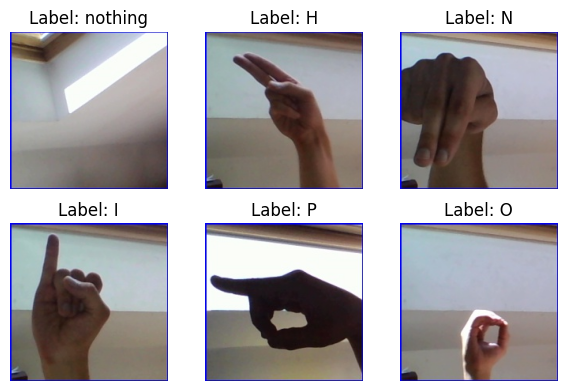

In [6]:
import random

# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(6, 4))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)

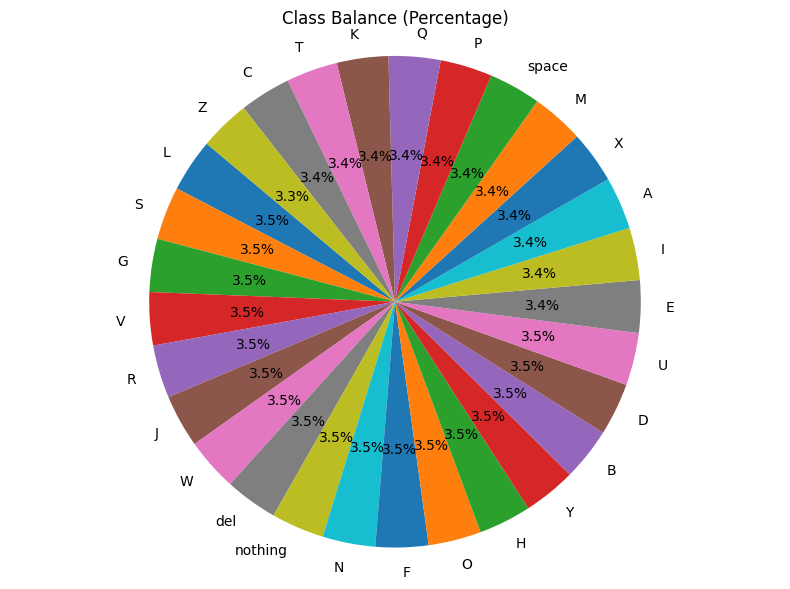

In [7]:
# Calculate class counts
class_counts = train_df['Labels'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(train_df)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(8, 6))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(150, 150, 3),
    pooling="max"
)

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(128),
    LeakyReLU(alpha=0.01),  # Adding LeakyReLU activation
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.01),  # Adding LeakyReLU activation
    Dropout(0.5),
    Dense(29, activation='softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 4 , verbose = 1 ,
    validation_steps= None, shuffle= False
   )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/4


I0000 00:00:1742989933.083836      99 service.cc:145] XLA service 0x784734002a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742989933.083910      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1742989933.083915      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1392 ━━━━━━━━━━━━━━━━━━━━ 17:07:10 44s/step - accuracy: 0.0000e+00 - loss: 4.0956

I0000 00:00:1742989956.754438      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1392/1392 ━━━━━━━━━━━━━━━━━━━━ 1056s 727ms/step - accuracy: 0.7168 - loss: 1.0480 - val_accuracy: 0.9536 - val_loss: 0.1603
Epoch 2/4
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 474s 340ms/step - accuracy: 0.9716 - loss: 0.1051 - val_accuracy: 0.9917 - val_loss: 0.0285
Epoch 3/4
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 464s 333ms/step - accuracy: 0.9827 - loss: 0.0652 - val_accuracy: 0.9869 - val_loss: 0.0512
Epoch 4/4
1392/1392 ━━━━━━━━━━━━━━━━━━━━ 460s 331ms/step - accuracy: 0.9868 - loss: 0.0489 - val_accuracy: 0.9968 - val_loss: 0.0140


In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

# save model
os.makedirs("/kaggle/working/models", exist_ok=True)
model.save(f'/kaggle/working/models/model_{int(test_accuracy*100)}.h5')

174/174 ━━━━━━━━━━━━━━━━━━━━ 78s 450ms/step - accuracy: 0.9983 - loss: 0.0077
Test Accuracy: 0.998275876045227


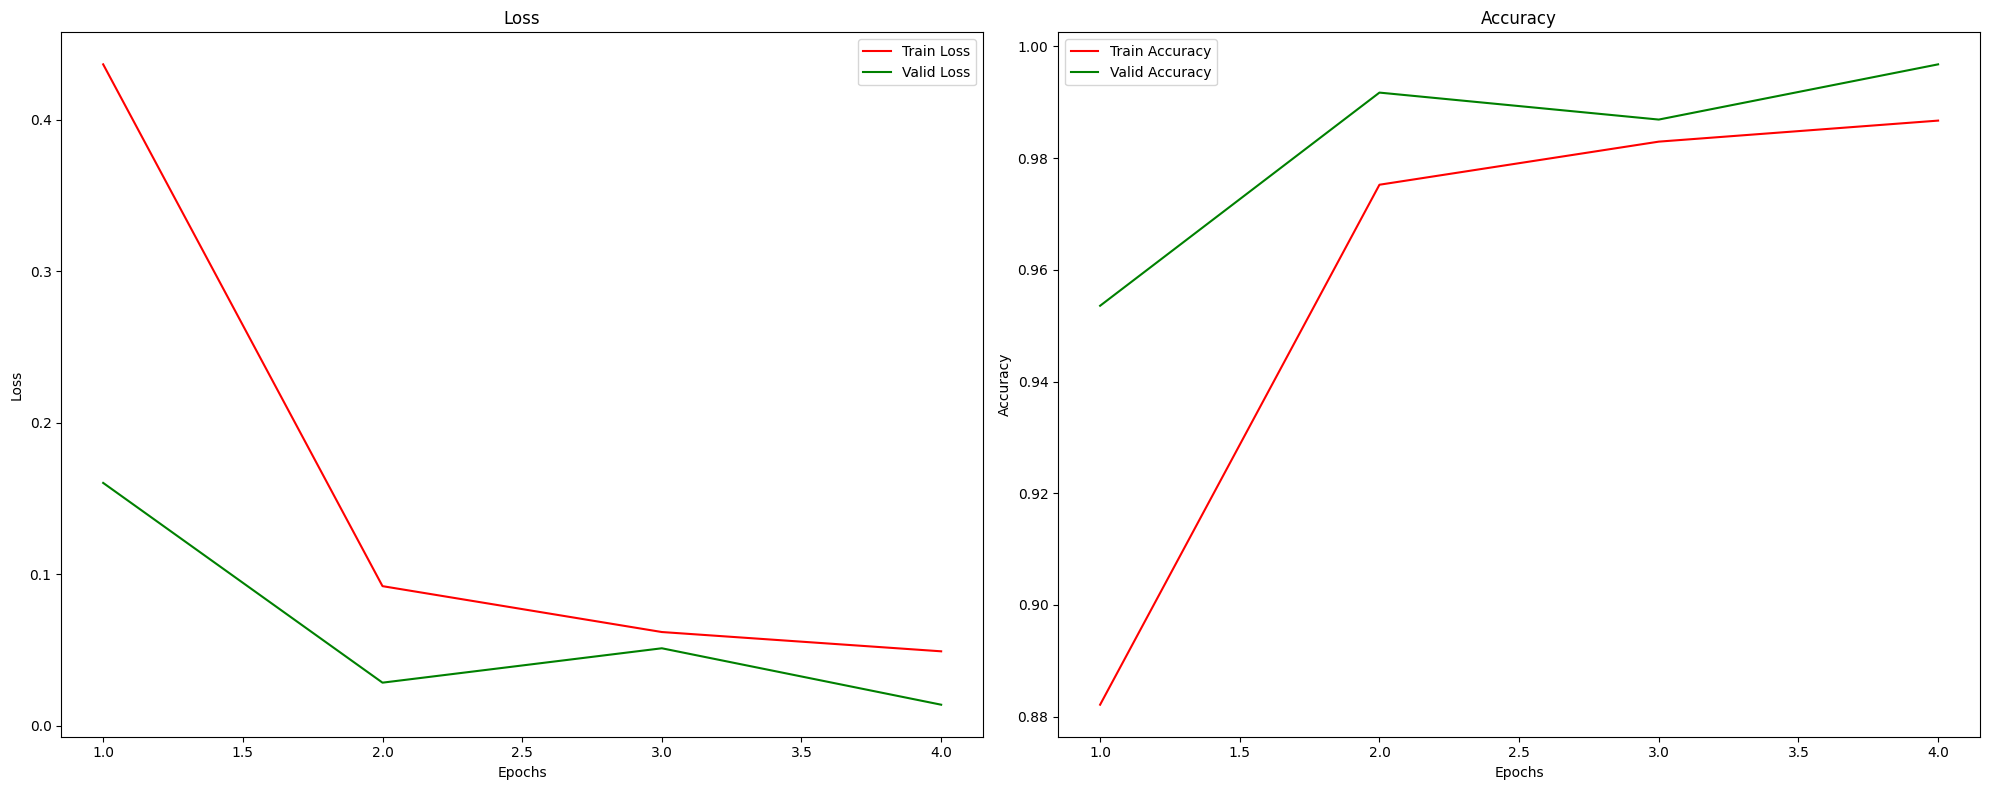

In [10]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [11]:
# Access class labels and corresponding indices
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
print("Class indices (Class name -> Index):", class_indices)
print("Index to Class mapping (Index -> Class name):", index_to_class)

Class indices (Class name -> Index): {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Index to Class mapping (Index -> Class name): {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}


In [13]:
with open('/kaggle/working/index_to_class_mapping.json', 'w') as json_file:
    index_to_class = json.dump(index_to_class, json_file)

In [14]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import json

# Load the JSON file that contains the index-to-class mapping
with open('/kaggle/working/index_to_class_mapping.json', 'r') as json_file:
    index_to_class = json.load(json_file)
    
model = load_model('/kaggle/working/models/model_99.h5')


# Load and preprocess the image
def get_label(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to 150x150
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch size
    img_array = img_array / 255.0  # Normalize by 255

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Get the predicted class label
    predicted_label = index_to_class[str(predicted_class[0])]
    
    return predicted_label

# Print the predicted label
img_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg'
predicted_label = get_label(img_path)
print(f"Predicted class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: B


In [15]:
import os
images = os.listdir("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test")

In [16]:
actual = []
predicted = []

for img in images:
    temp = img.split("_")[0]
    # print(temp)
    actual.append(temp)
    img_path = os.path.join("/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test", img)
    label = get_label(img_path)
    predicted.append(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [17]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actual, predicted)
print(accuracy)

1.0


In [18]:
import json
with open('/kaggle/working/index_to_class_mapping.json', 'w') as json_file:
    json.dump(index_to_class, json_file)

In [19]:
model.save_weights('/kaggle/working/models/model.weights.h5')